# Proyecto 1: Inteligencia Artificial Aplicada a la Ingeniería Eléctrica

## Algoritmo 1: K-means

In [11]:
# Importamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Importamos los datos del anexo A
csv_file = 'AnexoA.csv'
datosA = pd.read_csv(csv_file)
print(datosA.info())
print(datosA.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Empresa   133 non-null    object
 1   Circuito  133 non-null    object
 2   Abonados  133 non-null    int64 
 3   DPIR      133 non-null    int64 
 4   FPI       133 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 5.3+ KB
None
  Empresa             Circuito  Abonados  DPIR   FPI
0    CNFL       BARVA-CIPRESAL      3756  3273  2597
1    CNFL      CAJA-INDUSTRIAS      2230  2688  1423
2    CNFL      ESCAZÚ-PIEDADES      7039  2386  2446
3    CNFL    CORONADO-CASCAJAL      9777  2296  2682
4    CNFL  BRASIL-CIUDAD COLON      8644  2112  1852


In [4]:
# Importamos los datos del anexo b
csv_file = 'AnexoB.csv'
datosB = pd.read_csv(csv_file)
print(datosB.info())
print(datosB.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Empresa   352 non-null    object
 1   Circuito  352 non-null    object
 2   Abonados  352 non-null    int64 
 3   DPIR      352 non-null    int64 
 4   FPI       352 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 13.9+ KB
None
           Empresa             Circuito  Abonados  DPIR  FPI
0  COOPEALFARORUIZ         LAGUNA NORTE      3365   493  600
1  COOPEALFARORUIZ       ZARCERO CENTRO      1796   465  429
2  COOPEALFARORUIZ                 TORO       197   450  400
3  COOPEALFARORUIZ           SECTOR SUR      2762   344  400
4             CNFL  SABANILLA-SAN PEDRO      5933   564  324


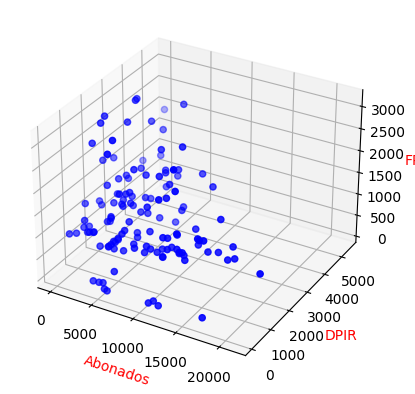

In [5]:
# Análisis exploratorio gráfica de los datos
xA = datosA.Abonados
yA = datosA.DPIR
zA = datosA.FPI

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xA, yA, zA, c='b', marker='o')
ax.set_xlabel('Abonados')
ax.set_ylabel('DPIR')
ax.set_zlabel('FPI')
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.zaxis.label.set_color('red')                           

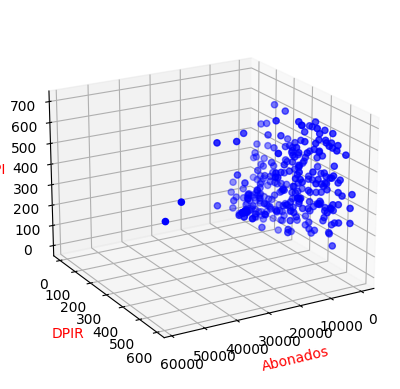

In [6]:
# Análisis exploratorio gráfica de los datos
xB = datosB.Abonados
yB = datosB.DPIR
zB = datosB.FPI

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xB, yB, zB, c='b', marker='o')
ax.set_xlabel('Abonados')
ax.set_ylabel('DPIR')
ax.set_zlabel('FPI')
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.zaxis.label.set_color('red')
ax.view_init(azim=60, elev=20) 

In [7]:
data = datosA.select_dtypes(include=[int])
scaler = StandardScaler() #investigar qué hace
data = scaler.fit_transform(data)

### Método del codo

Text(0.5, 1.0, 'Método del codo')

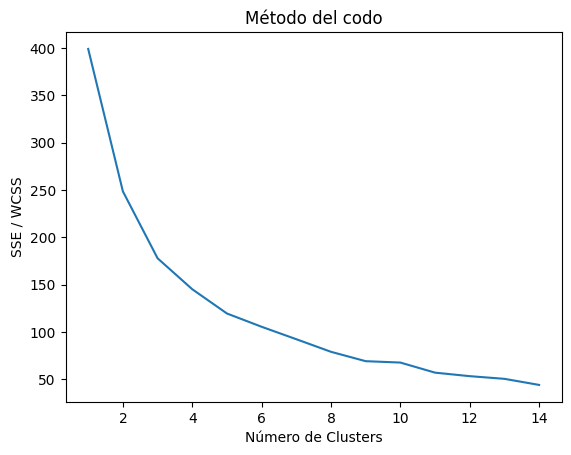

In [8]:
# Usamos el método del codo
sse = {}

for k in range(1,15):
  kmeans = KMeans(n_clusters=k ,max_iter=100)
  clusters = kmeans.fit_predict(data)
  sse[k] = kmeans.inertia_
  
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(sse.keys()),list(sse.values()))
ax.set_xlabel("Número de Clusters")
ax.set_ylabel("SSE / WCSS")
ax.set_title("Método del codo")

Visualisamos que el gráfico no converge, sino que sigue bajando indefinidamente. Se elige k = 8 porque no 

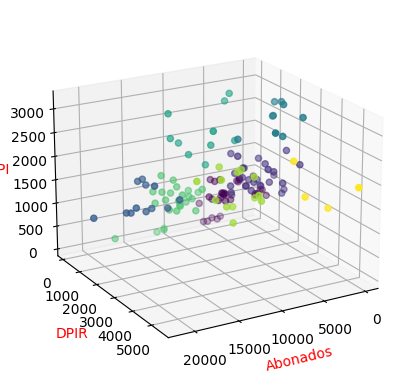

In [9]:
# Elegimos k = 8 a partir de la gráfica
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit(data)
y_means = kmeans.predict(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xA, yA, zA, c=y_means, marker='o')
ax.set_xlabel('Abonados')
ax.set_ylabel('DPIR')
ax.set_zlabel('FPI')
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.zaxis.label.set_color('red')
ax.view_init(azim=60, elev=20) 

### Coeficiente silueta

Text(0.5, 1.0, 'Método del Coeficiente silueta')

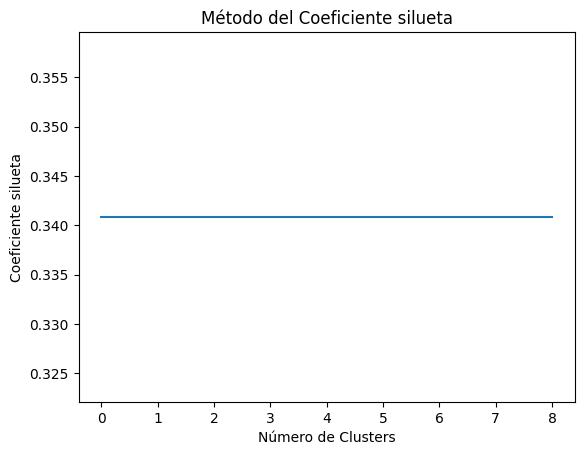

In [10]:
sc = {}

for n_clusters in range(0,9):# Maximum range should be 6, as it contains only 6 data points
      kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
      label = kmeans.labels_
      sil_coeff = silhouette_score(data,label,metric = 'euclidean')
      sc[n_clusters] = sil_coeff
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(sc.keys()),list(sc.values()))
ax.set_xlabel("Número de Clusters")
ax.set_ylabel("Coeficiente silueta")
ax.set_title("Método del Coeficiente silueta")

### DBSCAN

In [12]:
dbscan = DBSCAN(eps=0.49, min_samples=10)
dbscan.fit(data)


DBSCAN(eps=0.49, min_samples=10)

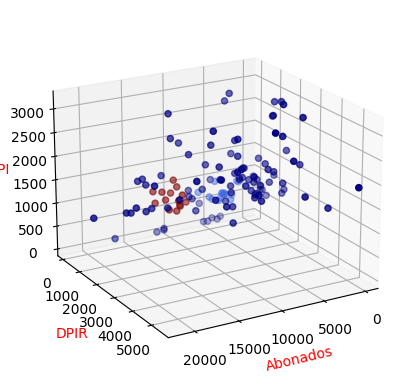

In [14]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xA, yA, zA, c=vectorizer(dbscan.labels_), marker='o')
ax.set_xlabel('Abonados')
ax.set_ylabel('DPIR')
ax.set_zlabel('FPI')
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.zaxis.label.set_color('red')
ax.view_init(azim=60, elev=20) 
